# Loading packages & data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from dmba import plotDecisionTree, classificationSummary
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [2]:
d = pd.read_csv('FlightDelays.csv')

# Data Preprocessing

## Cleaning

In [3]:
# Check if there are any invalid values
print("Null values present? ", d.isnull().values.any())
d.head()

Null values present?  False


CRS_DEP_TIME CARRIER  DEP_TIME DEST  DISTANCE     FL_DATE  FL_NUM ORIGIN  \
0          1455      OH      1455  JFK       184       37987    5935    BWI   
1          1640      DH      1640  JFK       213  2004-01-01    6155    DCA   
2          1245      DH      1245  LGA       229  2004-01-01    7208    IAD   
3          1715      DH      1709  LGA       229  2004-01-01    7215    IAD   
4          1039      DH      1035  LGA       229  2004-01-01    7792    IAD   

   Weather  DAY_WEEK  DAY_OF_MONTH TAIL_NUM Flight Status  
0        0         4             1   N940CA        ontime  
1        0         4             1   N405FJ        ontime  
2        0         4             1   N695BR        ontime  
3        0         4             1   N662BR        ontime  
4        0         4             1   N698BR        ontime

In [4]:
d.drop([0], axis=0, inplace=True) # Exclude first row with anomalous FL_DATE.
d.columns = d.columns.str.replace(' ','') # Remove spaces in column names.
d.columns = d.columns.str.replace('_','') # Remove underscores in column names.
d.rename(columns={'Weather':'WEATHER', # Capitalize
                  'FlightStatus':'STATUS'}, # Simplify
         inplace=True) # Rename column name to be capitalized.

In [5]:
# Pad time features with zeroes to prepare for formatting.
d['CRSDEPTIME'] = d['CRSDEPTIME'].astype(str)
d['CRSDEPTIME'] = d['CRSDEPTIME'].str.zfill(4)
d['CRSDEPTIME'] = pd.to_datetime(d['CRSDEPTIME'],format='%H%M')

d['DEPTIME'] = d['DEPTIME'].astype(str)
d['DEPTIME'] = d['DEPTIME'].str.zfill(4)
d['DEPTIME'] = pd.to_datetime(d['DEPTIME'],format='%H%M')
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 1 to 2200
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CRSDEPTIME  2200 non-null   datetime64[ns]
 1   CARRIER     2200 non-null   object        
 2   DEPTIME     2200 non-null   datetime64[ns]
 3   DEST        2200 non-null   object        
 4   DISTANCE    2200 non-null   int64         
 5   FLDATE      2200 non-null   object        
 6   FLNUM       2200 non-null   int64         
 7   ORIGIN      2200 non-null   object        
 8   WEATHER     2200 non-null   int64         
 9   DAYWEEK     2200 non-null   int64         
 10  DAYOFMONTH  2200 non-null   int64         
 11  TAILNUM     2200 non-null   object        
 12  STATUS      2200 non-null   object        
dtypes: datetime64[ns](2), int64(5), object(6)
memory usage: 223.6+ KB


In [6]:
# Derive the new feature, delays by minutes, as min_diff.
d['DELAYMINS'] = (d['DEPTIME'] - d['CRSDEPTIME']).dt.total_seconds() / 60.0
d['DELAYMINS'] = d['DELAYMINS'].astype(np.int64)

In [7]:
# Check if Flight_Status conforms to delay criterion.
has_correct_status = (d['STATUS']=='delayed') & (d['DELAYMINS']<15)
print("Count of original status incorrect by delay criterion: ", np.count_nonzero(has_correct_status))
d[['STATUS','DELAYMINS']]

Count of original status incorrect by delay criterion:  146


STATUS  DELAYMINS
1     ontime          0
2     ontime          0
3     ontime         -6
4     ontime         -4
5     ontime         -1
...      ...        ...
2196  ontime         -1
2197  ontime         -7
2198  ontime         -2
2199  ontime          4
2200  ontime          6

[2200 rows x 2 columns]

In [8]:
# Overwrite Flight_Status with criterion-compliant values.
new_status = []
for i in d['DELAYMINS']:
    if i < 15: 
        new_status.append("ontime") 
    else: 
        new_status.append("delayed")
d['FLIGHT_STATUS'] = new_status

has_correct_status = (d['STATUS']=='delayed') & (d['DELAYMINS']<15)
print("Count of incorrectly updated status by delay criterion: ",
      np.count_nonzero(has_correct_status))
has_correct_status1 = (d['STATUS']=='delayed') & (d['DELAYMINS']<15)
d[['STATUS','DELAYMINS']]

Count of incorrectly updated status by delay criterion:  146


STATUS  DELAYMINS
1     ontime          0
2     ontime          0
3     ontime         -6
4     ontime         -4
5     ontime         -1
...      ...        ...
2196  ontime         -1
2197  ontime         -7
2198  ontime         -2
2199  ontime          4
2200  ontime          6

[2200 rows x 2 columns]

## Data reduction & binning

In [9]:
# Drop redundant, irrelevant columns.
clean_column_names = ['CARRIER','ORIGIN','DISTANCE',
                      'DEST','DEPTIME','DELAYMINS',
                      'WEATHER','DAYWEEK','STATUS']
clean_d = d.reindex(columns=clean_column_names)

TAIL_NUM was excluded as it is only a unique identifier for a plane. 

FL_NUM was excluded similarly, given its purpose of identifying a flight which was already expressed through CARRIER, ORIGIN, and DEST.

FL_DATE was excluded as DAY_WEEK already provided a time element in the feature.

In [10]:
# Bin departure time by hours.
clean_d['DEPTIME'] = clean_d['DEPTIME'].dt.hour
time_bins = [0, 6, 12, 18, 24]
time_labels = ['Overnight', 'Morning',
               'Afternoon', 'Evening']
clean_d['DEPTIME'] = pd.cut(x=clean_d['DEPTIME'], 
                             bins=time_bins,
                             labels=time_labels,
                             include_lowest = True)
clean_d['DEPTIME'] = clean_d['DEPTIME'].astype('category')

In [11]:
# Export data with binned features to a CSV for pivot.
clean_d.to_csv('FlightDelaysDataExploration.csv',index=False)
clean_d

CARRIER ORIGIN  DISTANCE DEST    DEPTIME  DELAYMINS  WEATHER  DAYWEEK  \
1         DH    DCA       213  JFK  Afternoon          0        0        4   
2         DH    IAD       229  LGA    Morning          0        0        4   
3         DH    IAD       229  LGA  Afternoon         -6        0        4   
4         DH    IAD       229  LGA    Morning         -4        0        4   
5         DH    IAD       228  JFK    Morning         -1        0        4   
...      ...    ...       ...  ...        ...        ...      ...      ...   
2196      RU    DCA       199  EWR  Overnight         -1        0        6   
2197      RU    IAD       213  EWR  Afternoon         -7        0        6   
2198      RU    DCA       199  EWR  Afternoon         -2        0        6   
2199      RU    DCA       199  EWR  Afternoon          4        0        6   
2200      RU    DCA       199  EWR  Afternoon          6        0        6   

      STATUS  
1     ontime  
2     ontime  
3     ontime  
4     ontime  
5     ontime  
...      ...  
2196  ontime  
2197  ontime  
2198  ontime  
2199  ontime  
2200  ontime  

[2200 rows x 9 columns]

In [12]:
# Export data to a CSV for model building
clean_d.to_csv('FlightDelaysTrainingData.csv',index=False)

## Data Exploration

In [13]:
d1 = pd.read_csv('FlightDelaysDataExploration.csv')

In [14]:
# Further bin flight distances for a cleaner pivot.
min_dist = d1.DISTANCE.min()
max_dist = d1.DISTANCE.max()
dist_bin_size = (max_dist - min_dist)/4
dist_bins = [min_dist, min_dist + dist_bin_size, 
             max_dist - dist_bin_size, max_dist, 
             max_dist + dist_bin_size]
dist_labels = ['<184','184-198','199-213','>213']
d1['DISTANCE'] = pd.cut(x=d1['DISTANCE'], 
                             bins=dist_bins,
                             labels=dist_labels,
                             include_lowest = True)
d1['DISTANCE'] = d1['DISTANCE'].astype('category')

In [15]:
# Update CSV for pivot.
d1.to_csv('FlightDelaysDataExploration.csv')

<AxesSubplot:>

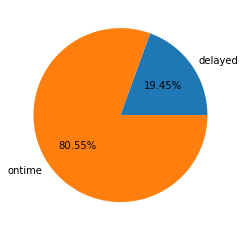

In [16]:
# Preview proportion of target variable.
d1.groupby('STATUS'
          ).size().plot(kind='pie',
                        autopct='%.2f%%',
                        ylabel="")

In [17]:
status_count_by_carrier = pd.pivot_table(d1,index='CARRIER',
                                         values='DELAYMINS',
                                         columns='STATUS',
                                         aggfunc='count',margins=True)
status_count_by_carrier

STATUS   delayed  ontime   All
CARRIER                       
CO            26      68    94
DH           137     414   551
DL            47     341   388
MQ            80     215   295
OH             4      25    29
RU            94     314   408
UA             5      26    31
US            35     369   404
All          428    1772  2200

In [18]:
# Obtain the average number of minutes from schedule that a flight leaves its origin.
worst_delay = pd.pivot_table(d1,index='ORIGIN',
                                         values='DELAYMINS',
                                         columns='STATUS',
                                   aggfunc=np.max)
worst_delay

STATUS  delayed  ontime
ORIGIN                 
BWI         265      20
DCA         187      30
IAD         231      37

In [19]:
# Number of flights delayed and on time based on departure time.
flight_status_by_time = pd.pivot_table(d1,index='STATUS',
                                         values='DELAYMINS',
                                         columns='DEPTIME',
                                   aggfunc='count')
flight_status_by_time

DEPTIME  Afternoon  Evening  Morning  Overnight
STATUS                                         
delayed        225       99       83         21
ontime         794      171      635        172

In [20]:
# Schedule reliability by time of day
carrier_schedule_reliability = pd.pivot_table(d1, index=['CARRIER',
                                                         'STATUS'],
                                              values='DELAYMINS', columns='DEPTIME',
                                              aggfunc='count', fill_value=0, margins=True)
carrier_schedule_reliability

DEPTIME          Afternoon  Evening  Morning  Overnight   All
CARRIER STATUS                                               
CO      delayed         16        7        3          0    26
        ontime          23        1       44          0    68
DH      delayed         73       38       21          5   137
        ontime         184       62      135         33   414
DL      delayed         27        9       11          0    47
        ontime         150       43      132         16   341
MQ      delayed         40       18       17          5    80
        ontime         104        5       75         31   215
OH      delayed          4        0        0          0     4
        ontime          25        0        0          0    25
RU      delayed         55       17       16          6    94
        ontime         165       18       77         54   314
UA      delayed          0        0        5          0     5
        ontime           0        0       26          0    26
US      delayed         10       10       10          5    35
        ontime         143       42      146         38   369
All                   1019      270      718        193  2200

<AxesSubplot:xlabel='DAYWEEK', ylabel='count'>

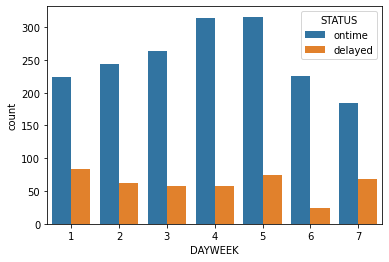

In [21]:
# Flight status by days of the week.
sns.countplot(data=d1,x='DAYWEEK',hue='STATUS')

# Model Building

In [22]:
the_d = pd.read_csv('FlightDelaysTrainingData.csv')

In [23]:
# Create a function to highlight dataframe columns in yellow.
def highlight_cols(s):
    return 'background-color: % s' % 'yellow'

In [24]:
# Exclude MINS_DIFF from predictors as it only served to determine appropriate FLIGHT_STATUS.
predictors = ['CARRIER','ORIGIN','DISTANCE','DEST',
              'DEPTIME','WEATHER','DAYWEEK']
outcome = 'STATUS'
y = the_d['STATUS']
classes = ['ontime', 'delayed']

# Emphasize in the dataframe which features will be predictors.
display(d.sample(5).style.applymap(highlight_cols, 
                          subset = pd.IndexSlice[:,predictors]))

In [25]:
# Transform predictors categorically, i.e. expressed only as 0 or 1.
X = pd.get_dummies(the_d[predictors])

In [26]:
# Split the data into training (60%) and testing (40%)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=42)

## Naive-Bayes Model

In [27]:
# Run the model
flight_nb = MultinomialNB(alpha=0.01)
flight_nb.fit(X_train, y_train)

MultinomialNB(alpha=0.01)

In [28]:
predProb_train = flight_nb.predict_proba(X_train)
predProb_valid = flight_nb.predict_proba(X_valid)
y_valid_pred = flight_nb.predict(X_valid)
y_train_pred = flight_nb.predict(X_train)

In [29]:
NB_results = pd.concat([pd.DataFrame({'actual': y_valid, 'predicted': y_valid_pred})], axis=1)
print(NB_results)

       actual predicted
1451   ontime    ontime
1334  delayed   delayed
1761   ontime    ontime
1735   ontime    ontime
1576   ontime    ontime
...       ...       ...
1839   ontime    ontime
236   delayed   delayed
551    ontime    ontime
520    ontime    ontime
1261  delayed    ontime

[880 rows x 2 columns]


In [30]:
nb_score = accuracy_score(y_valid, y_valid_pred)
classificationSummary(y_valid, y_valid_pred)

Confusion Matrix (Accuracy 0.8102)

       Prediction
Actual   0   1
     0  30 145
     1  22 683


## Classification and Regression Tree Model

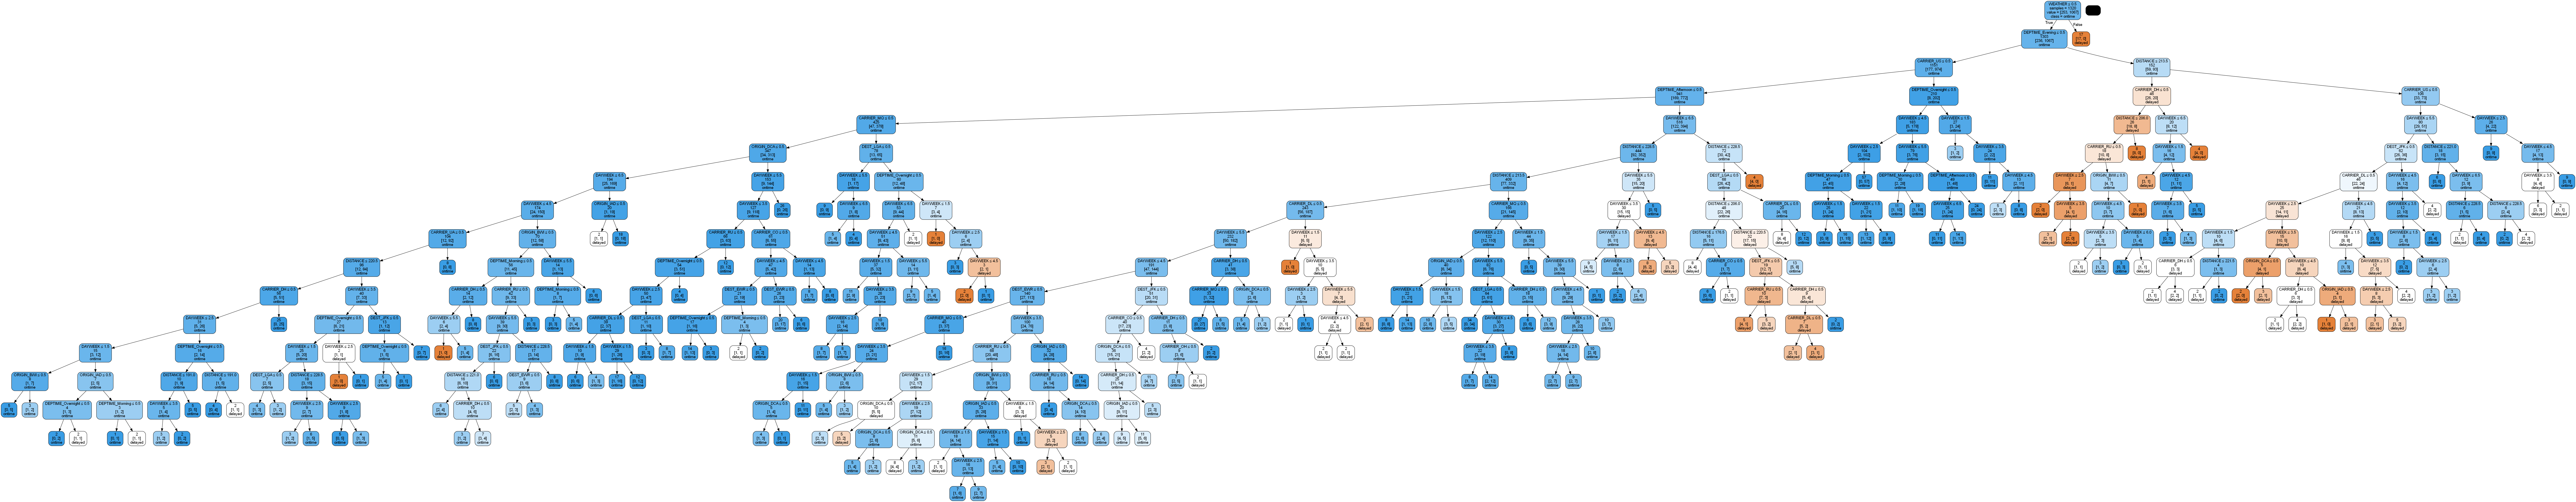

In [31]:
classTree = DecisionTreeClassifier(random_state=0)
classTree.fit(X_train, y_train)
wildtree_ypred = classTree.predict(X_valid)
plotDecisionTree(classTree,
                 feature_names=X.columns,
                 class_names=classTree.classes_)

In [32]:
score_wildtree = accuracy_score(y_valid, wildtree_ypred)
print("Accuracy:", score_wildtree)

Accuracy: 0.7522727272727273


### Pruning

In [33]:
# Start with an initial guess for parameters
param_grid ={ # randomly assigned
    'max_depth': [2,5,9,14],
    'min_samples_split': [20,40,60,80,100],
    'min_impurity_decrease': [0,0.0005,0.001,0.005,0.01]
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=42),
                         param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X_train, y_train)
print('Initial score: ', gridSearch.best_params_)

Initial score:  {'max_depth': 2, 'min_impurity_decrease': 0, 'min_samples_split': 20}


In [34]:
# Adapt grid based on the initial search
param_grid = {
    'max_depth': list(range(2,16)), # 14 values
    'min_samples_split': list(range(10,22)), # 11 values
    'min_impurity_decrease': [0.0009,0.001,0.0011] # 3 values
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=42),
                         param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X_train, y_train)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

Improved score:  0.8212121212121213
Improved parameters:  {'max_depth': 2, 'min_impurity_decrease': 0.0009, 'min_samples_split': 10}


In [35]:
# Determine optimal depth
bonsai_params = gridSearch.best_estimator_
bonsai_params

DecisionTreeClassifier(max_depth=2, min_impurity_decrease=0.0009,
                       min_samples_split=10, random_state=42)

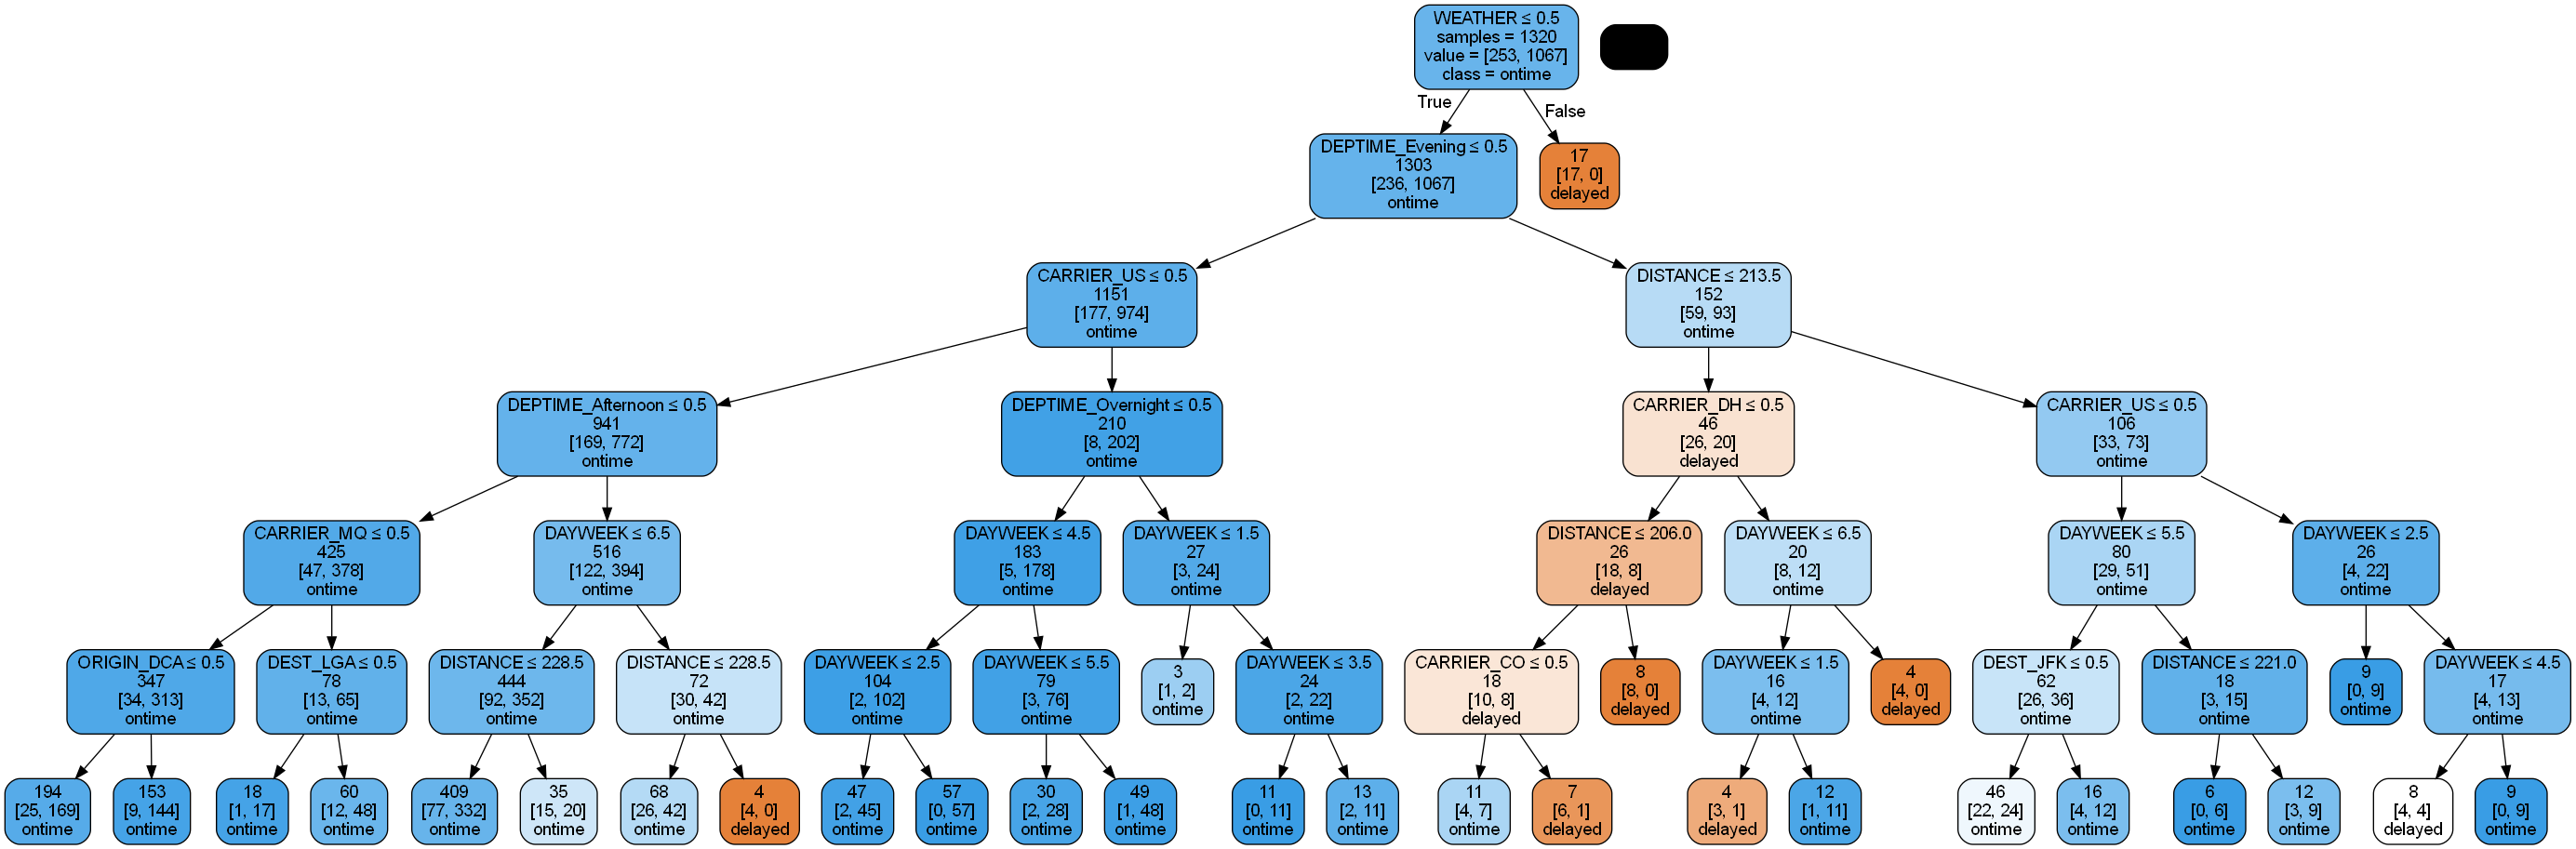

In [36]:
# Apply optimal depth to new CART
bonsai = DecisionTreeClassifier(max_depth=6, random_state=42)
bonsai.fit(X_train, y_train)
bonsai_ypred = bonsai.predict(X_valid)
plotDecisionTree(bonsai,
                 feature_names=X.columns,
                 class_names=bonsai.classes_)

In [37]:
bonsai_score = accuracy_score(y_valid, bonsai_ypred)
classificationSummary(y_valid, bonsai_ypred)

Confusion Matrix (Accuracy 0.8125)

       Prediction
Actual   0   1
     0  24 151
     1  14 691


### Verification of optimal depth by inspecting adjacent depths.

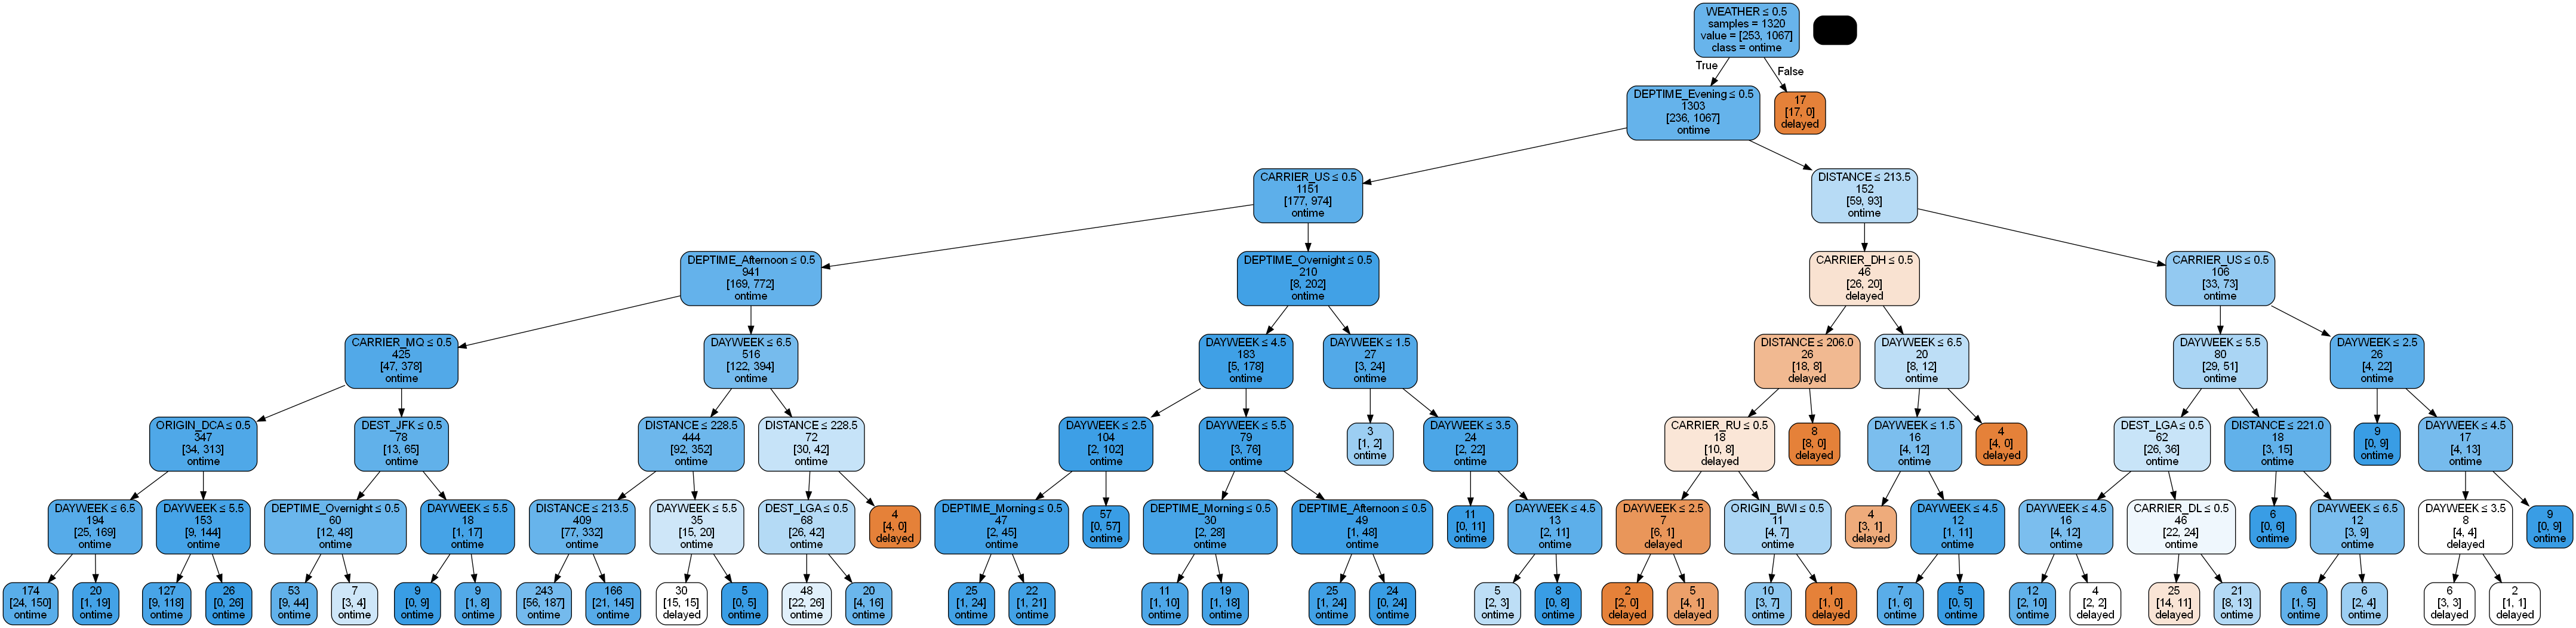

In [38]:
# Try +1 depth to best CART
bonsai1 = DecisionTreeClassifier(max_depth=7, random_state=42)
bonsai1.fit(X_train, y_train)
bonsai1_ypred = bonsai1.predict(X_valid)
plotDecisionTree(bonsai1,
                 feature_names=X.columns,
                 class_names=bonsai1.classes_)

In [39]:
bonsai1_score = accuracy_score(y_valid, bonsai1_ypred)
print("Accuracy:", bonsai1_score)

Accuracy: 0.8056818181818182


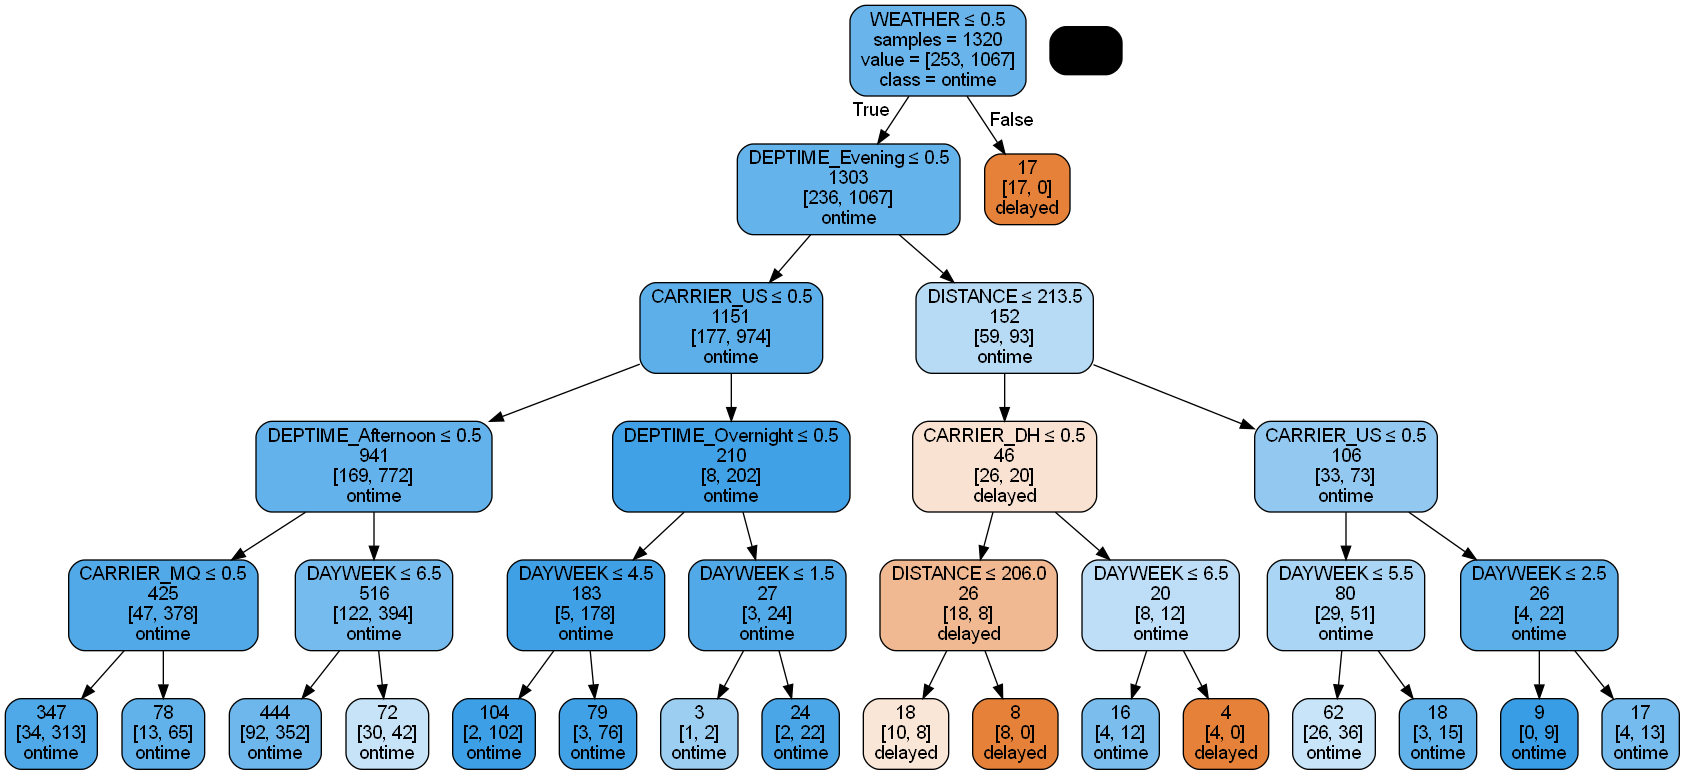

In [40]:
# Try -1 depth to best CART
bonsai2 = DecisionTreeClassifier(max_depth=5, random_state=42)
bonsai2.fit(X_train, y_train)
bonsai2_ypred = bonsai2.predict(X_valid)
plotDecisionTree(bonsai2,
                 feature_names=X.columns,
                 class_names=bonsai2.classes_)

In [41]:
bonsai2_score = accuracy_score(y_valid, bonsai2_ypred)
print("Accuracy:", bonsai2_score)

Accuracy: 0.8147727272727273


## Logistic Regression

In [42]:
# Fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(X_train, y_train)

LogisticRegression(C=1e+42, solver='liblinear')

In [43]:
lr_ypred = logit_reg.predict(X_valid)
lr_score = accuracy_score(y_valid, lr_ypred)
classificationSummary(y_valid, lr_ypred)

Confusion Matrix (Accuracy 0.8170)

       Prediction
Actual   0   1
     0  23 152
     1   9 696


In [44]:
lr_proba = logit_reg.predict_proba(X_valid)
logit_result = pd.DataFrame({'Actual': y_valid, 
                             'p(0)': [p[0] for p in lr_proba],
                             'p(1)': [p[1] for p in lr_proba],
                             'Predicted': lr_ypred })
logit_result_sorted = logit_result.sort_values(by=['p(1)'], ascending=False)
logit_result_sorted

Actual      p(0)      p(1) Predicted
1834  delayed  0.021498  0.978502    ontime
272    ontime  0.021498  0.978502    ontime
808    ontime  0.021498  0.978502    ontime
271    ontime  0.021498  0.978502    ontime
1309   ontime  0.021498  0.978502    ontime
...       ...       ...       ...       ...
1830  delayed  0.979374  0.020626   delayed
1889  delayed  0.980095  0.019905   delayed
1891  delayed  0.980095  0.019905   delayed
1868  delayed  0.981060  0.018940   delayed
1827  delayed  0.987053  0.012947   delayed

[880 rows x 4 columns]

In [45]:
# Show coefficients for logistic equation
print('Intercept ', logit_reg.intercept_[0])
pd.DataFrame({'Predictors':X.columns,'Coefficients': logit_reg.coef_[0]
             }).style.hide(axis='index')

Intercept  -0.008606078154460923


# Model Performance

1. Naive Bayes

In [46]:
classification_report(y_valid, y_valid_pred, target_names=classes)

'              precision    recall  f1-score   support\n\n      ontime       0.58      0.17      0.26       175\n     delayed       0.82      0.97      0.89       705\n\n    accuracy                           0.81       880\n   macro avg       0.70      0.57      0.58       880\nweighted avg       0.78      0.81      0.77       880\n'

2. Classification and Regression Tree

In [47]:
print(classification_report(y_valid, bonsai_ypred, target_names=classes))

              precision    recall  f1-score   support

      ontime       0.63      0.14      0.23       175
     delayed       0.82      0.98      0.89       705

    accuracy                           0.81       880
   macro avg       0.73      0.56      0.56       880
weighted avg       0.78      0.81      0.76       880



3. Logistic Regression

In [48]:
print(classification_report(y_valid, lr_ypred, target_names=classes))

              precision    recall  f1-score   support

      ontime       0.72      0.13      0.22       175
     delayed       0.82      0.99      0.90       705

    accuracy                           0.82       880
   macro avg       0.77      0.56      0.56       880
weighted avg       0.80      0.82      0.76       880



In [49]:
performance_summary = pd.DataFrame({'Model':['Naive Bayes','Decision Trees',
                                    'Logistic Regression'],'% Accuracy':
                                    [nb_score*100, bonsai_score*100, lr_score*100]
                                   }).style.hide(axis='index')
performance_summary

# Testing the Model on Sample Data

As it is unlikely that a combination of values have not yet been expressed in the original data, 5 samples will be randomly drawn therefrom.

In [50]:
# Randomly select 5 rows from dummied training data and export as a CSV.
s = X.sample(5)
s

DISTANCE  WEATHER  DAYWEEK  CARRIER_CO  CARRIER_DH  CARRIER_DL  \
1735       229        0        7           0           1           0   
2182       214        0        6           0           0           0   
1585       213        0        4           0           1           0   
669        214        0        6           0           0           0   
1180       213        0        6           0           0           0   

      CARRIER_MQ  CARRIER_OH  CARRIER_RU  CARRIER_UA  ...  ORIGIN_BWI  \
1735           0           0           0           0  ...           0   
2182           0           0           0           0  ...           0   
1585           0           0           0           0  ...           0   
669            0           0           0           0  ...           0   
1180           1           0           0           0  ...           0   

      ORIGIN_DCA  ORIGIN_IAD  DEST_EWR  DEST_JFK  DEST_LGA  DEPTIME_Afternoon  \
1735           0           1         0         0         1                  1   
2182           1           0         0         0         1                  1   
1585           0           1         1         0         0                  1   
669            1           0         0         0         1                  0   
1180           1           0         0         1         0                  0   

      DEPTIME_Evening  DEPTIME_Morning  DEPTIME_Overnight  
1735                0                0                  0  
2182                0                0                  0  
1585                0                0                  0  
669                 0                1                  0  
1180                0                0                  1  

[5 rows x 21 columns]

In [51]:
# Create a function to reverse pandas.get_dummies()
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [52]:
sample_d = undummify(s) # Revert to match training data format.

# Reorder columns
sample_columns = predictors
sample_columns.append('STATUS')
sample_d = sample_d.reindex(columns=sample_columns)

sample_d.to_csv('FlightDelaysTestingData.csv',
                index=False) # Export to CSV.
sample_d.style.hide(axis='index') # Check

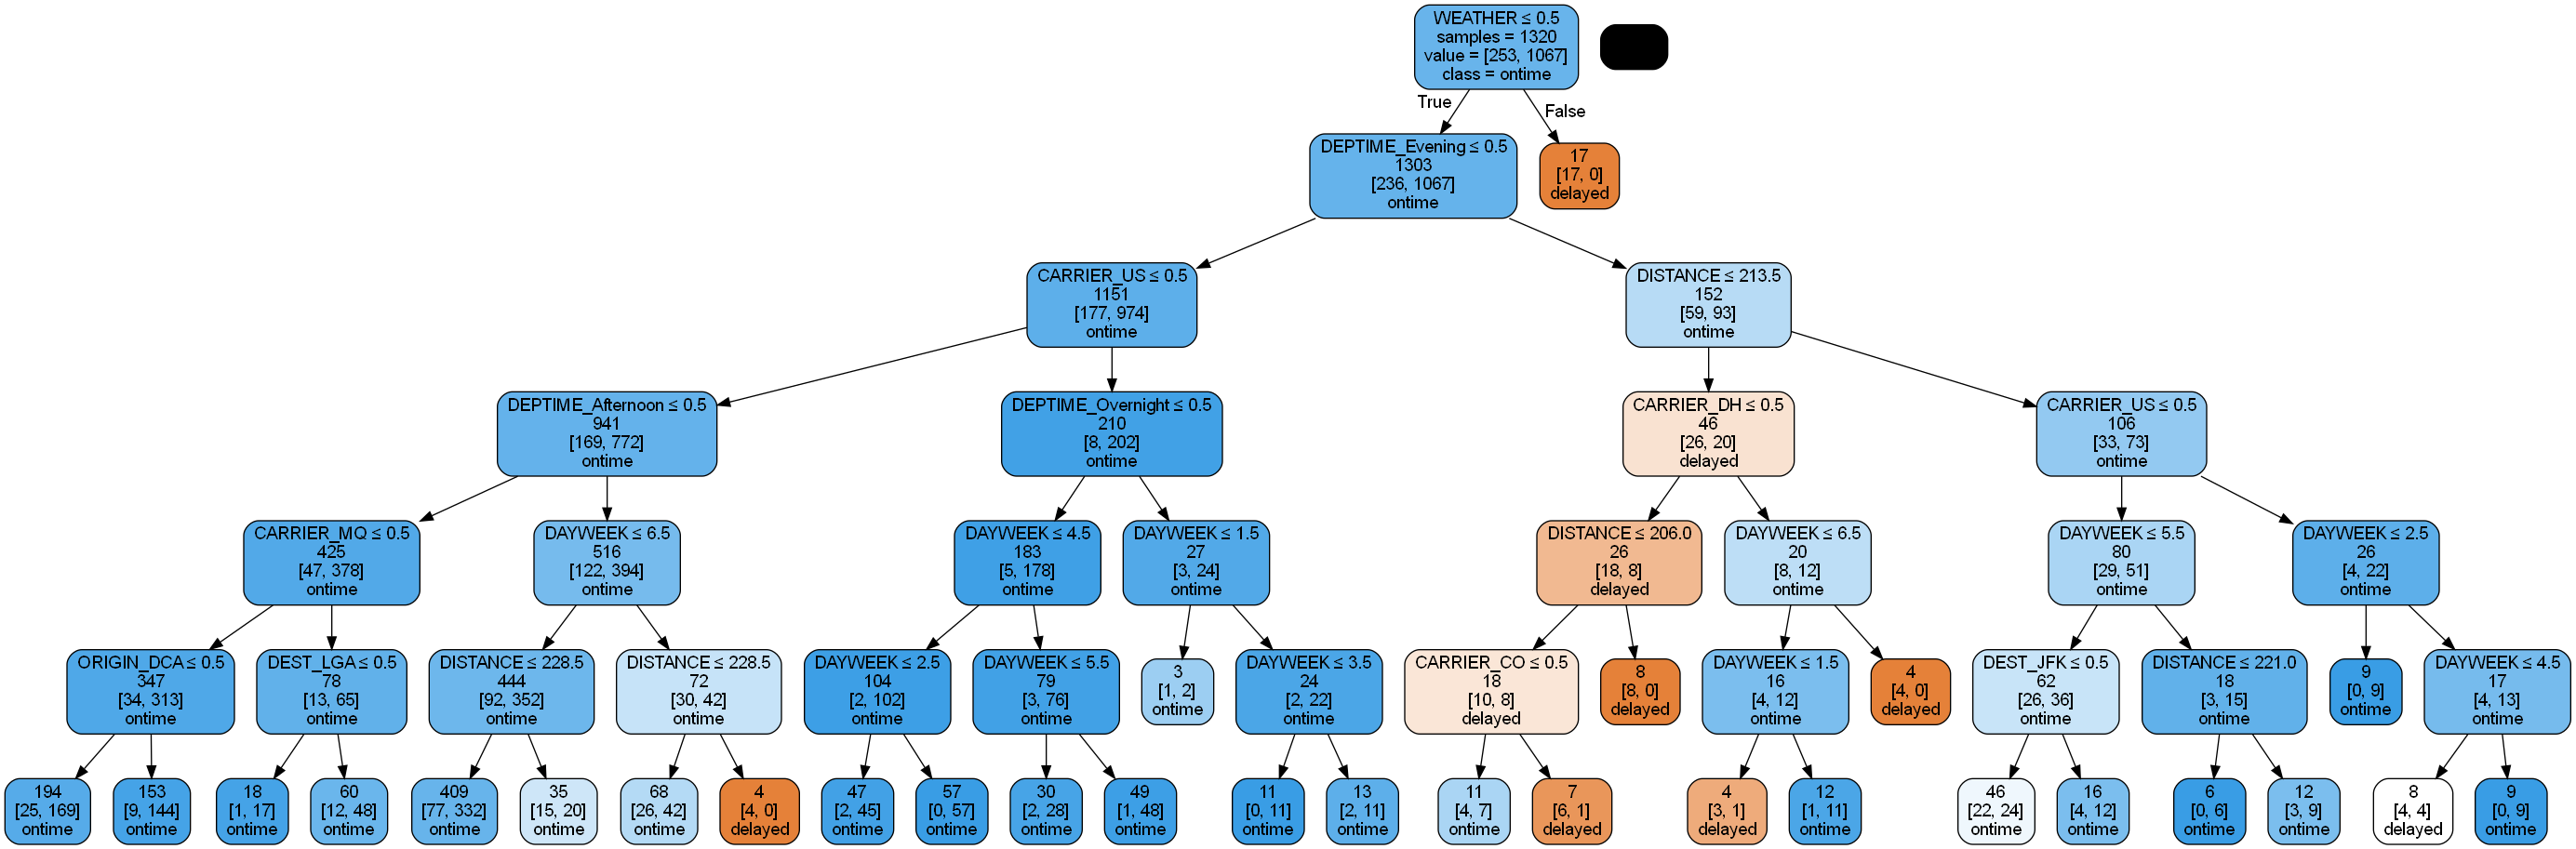

In [53]:
# CART with a max depth of 6. 
bonsai_ypred = bonsai.predict(s)
plotDecisionTree(bonsai,
                 feature_names=s.columns,
                 class_names=bonsai.classes_)

In [54]:
# Display STATUS prediction adjacent to sample features.
sample_d['STATUS'] = bonsai_ypred
display(sample_d.style.applymap(highlight_cols, 
                          subset = pd.IndexSlice[:,'STATUS']))